# Installing

In [ ]:
# innstall java 8
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# install spark (change the version number if needed)
!wget -q https://archive.apache.org/dist/spark/spark-3.0.0/spark-3.0.0-bin-hadoop3.2.tgz

# unzip the spark file to the current folder
!tar xf spark-3.0.0-bin-hadoop3.2.tgz

# set your spark folder to your system path environment.
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-bin-hadoop3.2"


# install findspark using pip
!pip install -q findspark

In [ ]:
import findspark
findspark.init()

import pyspark
from pyspark.sql import SparkSession, Row
from pyspark.sql.types import StructType, StructField, StringType
from pyspark.sql.functions import *
from pyspark.sql.window import Window
import pandas as pd
import random
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize SparkSession
spark = SparkSession.builder \
    .appName("MovieLens Data Processing") \
    .getOrCreate()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Preprocessing

In [ ]:
# Age group dictionary retrieved from dataset description
age_group_dict = {
    1:  "Under 18",
    18:  "18-24",
    25:  "25-34",
    35:  "35-44",
    45:  "45-49",
    50:  "50-55",
    56:  "56+"
}

In [ ]:
# Occupation dictionary retrieved from dataset description
occupation_dict = {
    0:  "other or not specified",
    1:  "academic/educator",
    2:  "artist",
    3:  "clerical/admin",
    4:  "college/grad student",
    5:  "customer service",
    6:  "doctor/health care",
    7:  "executive/managerial",
    8:  "farmer",
    9:  "homemaker",
    10:  "K-12 student",
    11:  "lawyer",
    12:  "programmer",
    13:  "retired",
    14:  "sales/marketing",
    15:  "scientist",
    16:  "self-employed",
    17:  "technician/engineer",
    18:  "tradesman/craftsman",
    19:  "unemployed",
    20:  "writer"
}

## Movies

In [ ]:
# Load data
movies_dat = spark.read.text("/content/drive/MyDrive/Colab Notebooks/BIg Data/movies.dat")
movies_dat.show(5)

+--------------------+
|               value|
+--------------------+
|1::Toy Story (199...|
|2::Jumanji (1995)...|
|3::Grumpier Old M...|
|4::Waiting to Exh...|
|5::Father of the ...|
+--------------------+
only showing top 5 rows



In [ ]:
movies_rdd = movies_dat.rdd.map(lambda lines: lines.value.split("::"))
movies_df = movies_rdd.map(lambda x: Row(MovieID=x[0], Title=x[1].split("(")[0], Year=x[1][x[1].rfind("(")+1:x[1].rfind(")")], Genres=x[2])).toDF()

movies_df.show(5)

+-------+--------------------+----+--------------------+
|MovieID|               Title|Year|              Genres|
+-------+--------------------+----+--------------------+
|      1|          Toy Story |1995|Animation|Childre...|
|      2|            Jumanji |1995|Adventure|Childre...|
|      3|   Grumpier Old Men |1995|      Comedy|Romance|
|      4|  Waiting to Exhale |1995|        Comedy|Drama|
|      5|Father of the Bri...|1995|              Comedy|
+-------+--------------------+----+--------------------+
only showing top 5 rows



In [ ]:
print("Movie Data shape: ", (movies_df.count(), len(movies_df.columns)))

Movie Data shape:  (3883, 4)


### Example

In [ ]:
movies_df.filter("MovieID=1").show(5)

+-------+----------+----+--------------------+
|MovieID|     Title|Year|              Genres|
+-------+----------+----+--------------------+
|      1|Toy Story |1995|Animation|Childre...|
+-------+----------+----+--------------------+



In [ ]:
movies_df.filter("Genres == 'Action'").show(5)

+-------+--------------------+----+------+
|MovieID|               Title|Year|Genres|
+-------+--------------------+----+------+
|      9|       Sudden Death |1995|Action|
|     20|        Money Train |1995|Action|
|     71|          Fair Game |1995|Action|
|    145|           Bad Boys |1995|Action|
|    204|Under Siege 2: Da...|1995|Action|
+-------+--------------------+----+------+
only showing top 5 rows



In [ ]:
movies_df.select("Title").show(5)

+--------------------+
|               Title|
+--------------------+
|          Toy Story |
|            Jumanji |
|   Grumpier Old Men |
|  Waiting to Exhale |
|Father of the Bri...|
+--------------------+
only showing top 5 rows



## Ratings

In [ ]:
# Load ratings data
ratings_dat = spark.read.text("/content/drive/MyDrive/Colab Notebooks/BIg Data/ratings.dat")
ratings_dat.show(5)

+--------------------+
|               value|
+--------------------+
|1::1193::5::97830...|
|1::661::3::978302109|
|1::914::3::978301968|
|1::3408::4::97830...|
|1::2355::5::97882...|
+--------------------+
only showing top 5 rows



In [ ]:
# Split the 'value' column into multiple columns
colName = ["UserID", "MovieID", "Rating", "Timestamp"]
ratings_rdd = ratings_dat.withColumn("value", split(ratings_dat["value"], "::"))
ratings_df = ratings_rdd.select([ratings_rdd.value.getItem(i).alias(colName[i]) for i in range(len(colName))])

ratings_df.show(5)

+------+-------+------+---------+
|UserID|MovieID|Rating|Timestamp|
+------+-------+------+---------+
|     1|   1193|     5|978300760|
|     1|    661|     3|978302109|
|     1|    914|     3|978301968|
|     1|   3408|     4|978300275|
|     1|   2355|     5|978824291|
+------+-------+------+---------+
only showing top 5 rows



### Ratings Data Analysis
**Using the df_rating variable for analysis only**

In [ ]:
# df_rating = ratings_df.withColumn('Timestamp',from_unixtime(col('Timestamp'))) \
# .withColumn('year',date_format(col("Timestamp"), "yyyy")) \
# .withColumn('month',date_format(col("Timestamp"), "mm")) \
# .withColumn('date',date_format(col("Timestamp"), "yyyy-mm-dd"))
# df_rating.show()
df_rating = ratings_df.withColumn("Timestamp", from_unixtime(col("Timestamp"))) \
.withColumn("year", year("Timestamp")) \
.withColumn("month", month("Timestamp")) \
.withColumn("date", to_date("Timestamp"))

# Step 5: Sort DataFrame by timestamp
df_rating = df_rating.orderBy("Timestamp")

# Step 6: Reset index (equivalent to Pandas reset_index(drop=True))
window = Window.orderBy(monotonically_increasing_id())
df_rating = df_rating.withColumn("index", row_number().over(window) - 1)

# Step 7: Display the DataFrame
df_rating.show()

+------+-------+------+-------------------+----+-----+----------+-----+
|UserID|MovieID|Rating|          Timestamp|year|month|      date|index|
+------+-------+------+-------------------+----+-----+----------+-----+
|  6040|    858|     4|2000-04-25 23:05:32|2000|    4|2000-04-25|    0|
|  6040|    593|     5|2000-04-25 23:05:54|2000|    4|2000-04-25|    1|
|  6040|   2384|     4|2000-04-25 23:05:54|2000|    4|2000-04-25|    2|
|  6040|   1961|     4|2000-04-25 23:06:17|2000|    4|2000-04-25|    3|
|  6040|   2019|     5|2000-04-25 23:06:17|2000|    4|2000-04-25|    4|
|  6040|    573|     4|2000-04-25 23:07:36|2000|    4|2000-04-25|    5|
|  6040|   1419|     3|2000-04-25 23:07:36|2000|    4|2000-04-25|    6|
|  6040|    213|     5|2000-04-25 23:07:36|2000|    4|2000-04-25|    7|
|  6040|   3111|     5|2000-04-25 23:07:36|2000|    4|2000-04-25|    8|
|  6040|   3505|     4|2000-04-25 23:07:36|2000|    4|2000-04-25|    9|
|  6040|   1734|     2|2000-04-25 23:08:01|2000|    4|2000-04-25

**Dropping Outlier**

In [ ]:
condition = (col("year").between(2000, 2099)) & (col("Rating").between(1, 5))
df_rating = df_rating.filter(condition)
df_rating.show()

+------+-------+------+-------------------+----+-----+----------+-----+
|UserID|MovieID|Rating|          Timestamp|year|month|      date|index|
+------+-------+------+-------------------+----+-----+----------+-----+
|  6040|    858|     4|2000-04-25 23:05:32|2000|    4|2000-04-25|    0|
|  6040|    593|     5|2000-04-25 23:05:54|2000|    4|2000-04-25|    1|
|  6040|   2384|     4|2000-04-25 23:05:54|2000|    4|2000-04-25|    2|
|  6040|   1961|     4|2000-04-25 23:06:17|2000|    4|2000-04-25|    3|
|  6040|   2019|     5|2000-04-25 23:06:17|2000|    4|2000-04-25|    4|
|  6040|    573|     4|2000-04-25 23:07:36|2000|    4|2000-04-25|    5|
|  6040|   1419|     3|2000-04-25 23:07:36|2000|    4|2000-04-25|    6|
|  6040|    213|     5|2000-04-25 23:07:36|2000|    4|2000-04-25|    7|
|  6040|   3111|     5|2000-04-25 23:07:36|2000|    4|2000-04-25|    8|
|  6040|   3505|     4|2000-04-25 23:07:36|2000|    4|2000-04-25|    9|
|  6040|   1734|     2|2000-04-25 23:08:01|2000|    4|2000-04-25

In [ ]:
unique_years = df_rating.select("year").distinct().rdd.flatMap(lambda x: x).collect()
unique_months = df_rating.select("month").distinct().rdd.flatMap(lambda x: x).collect()

# Unique number of users and movies
unique_users = df_rating.select("UserID").distinct().count()
unique_movies = df_rating.select("MovieID").distinct().count()

# Unique ratings
unique_ratings = df_rating.select("Rating").distinct().rdd.flatMap(lambda x: x).collect()

# Average rating
average_rating = df_rating.selectExpr("avg(Rating) as avg_rating").collect()[0]["avg_rating"]

# Frequency of each rating value
rating_counts = df_rating.groupBy("Rating").count().orderBy("Rating")

# Step 4: Display the results
print("Years:", unique_years)
print("Months:", unique_months)
print("#Unique users:", unique_users)
print("#Unique movies:", unique_movies)
print("Unique ratings:", unique_ratings)
print("Average rating:", average_rating)
print("Frequency of each rating value:")
rating_counts.show()

Years: [2003, 2001, 2000, 2002]
Months: [12, 1, 6, 3, 5, 9, 4, 8, 7, 10, 11, 2]
#Unique users: 6040
#Unique movies: 3706
Unique ratings: ['3', '5', '1', '4', '2']
Average rating: 3.581564453029317
Frequency of each rating value:
+------+------+
|Rating| count|
+------+------+
|     1| 56174|
|     2|107557|
|     3|261197|
|     4|348971|
|     5|226310|
+------+------+



### Number of ratings each year

In [ ]:
dfpd_rating = df_rating[['year', 'Rating']]
rating_counts_per_year = dfpd_rating.groupby('year').count().orderBy('year')

# Convert Spark DataFrame to Pandas DataFrame for plotting
rating_counts_per_year_pandas = rating_counts_per_year.toPandas()

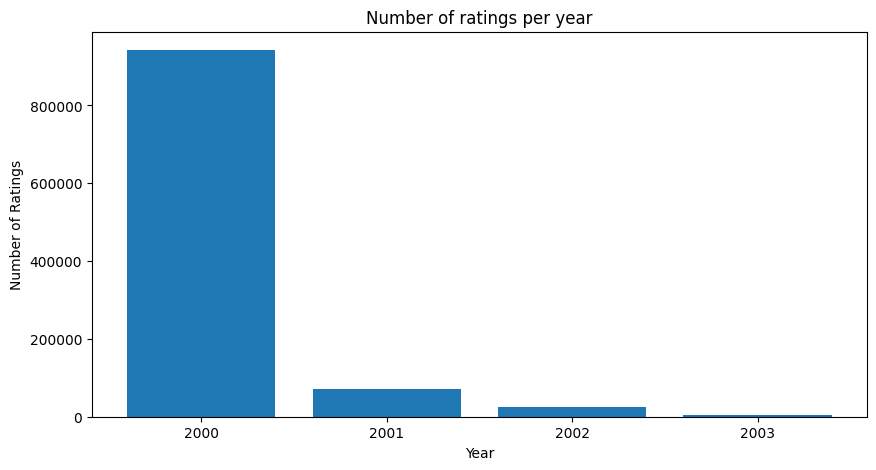

In [ ]:
plt.figure(figsize=(10, 5))
plt.bar(rating_counts_per_year_pandas['year'], rating_counts_per_year_pandas['count'])
plt.title('Number of ratings per year')
plt.xlabel('Year')
plt.ylabel('Number of Ratings')

# Set x-axis ticks to exact years
plt.xticks(rating_counts_per_year_pandas['year'])

plt.show()

+-----+--------+
|month|  rating|
+-----+--------+
|   12|29561.75|
|    1|  5768.0|
|    6| 15277.5|
|    3| 2134.25|
|    5| 18569.5|
|    9|14197.75|
|    4| 4851.75|
|    8| 47168.5|
|    7| 24251.0|
|   10| 11375.0|
|   11|73865.25|
|    2|  3032.0|
+-----+--------+



<Axes: title={'center': 'Average number of ratings per month'}, xlabel='month'>

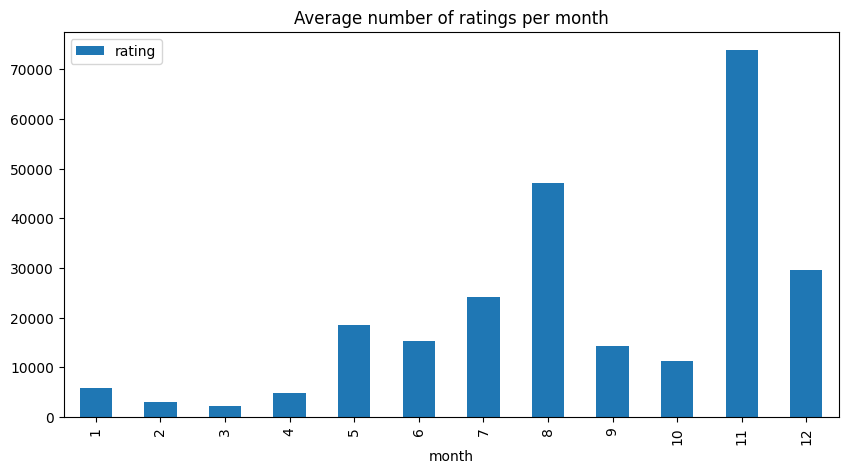

In [ ]:
df_temp = df_rating.groupBy('month').count().select(col('month'), (col('count') / 4).alias('rating'))

# Show the Spark DataFrame
df_temp.show()

# Plotting with Spark DataFrame is different and usually requires additional libraries.
# If you want to plot using Spark DataFrame, you can convert it back to a pandas DataFrame and plot using matplotlib or other plotting libraries.
# Here's how you can convert Spark DataFrame to pandas DataFrame and plot:

# Convert Spark DataFrame to pandas DataFrame
pandas_df = df_temp.toPandas()
pandas_df.sort_values(by="month", ascending=True, inplace=True)
# Plot using pandas DataFrame
pandas_df.plot.bar(x='month', y='rating', title='Average number of ratings per month', figsize=(10, 5))

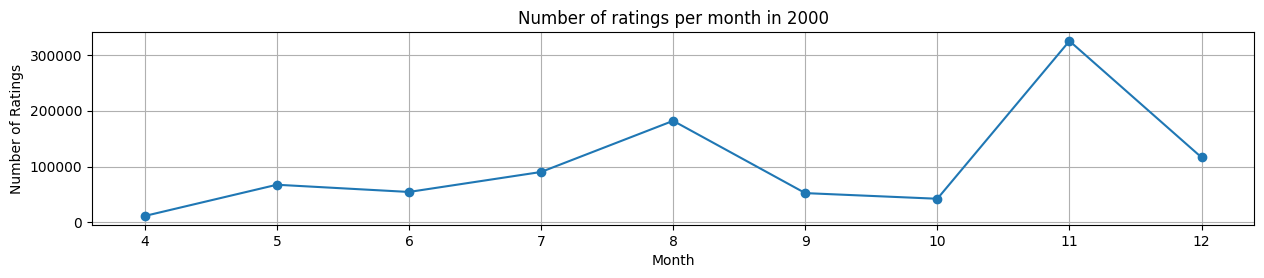

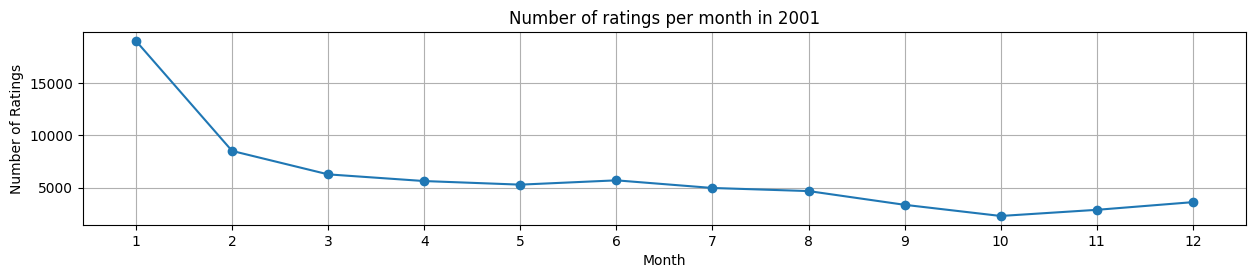

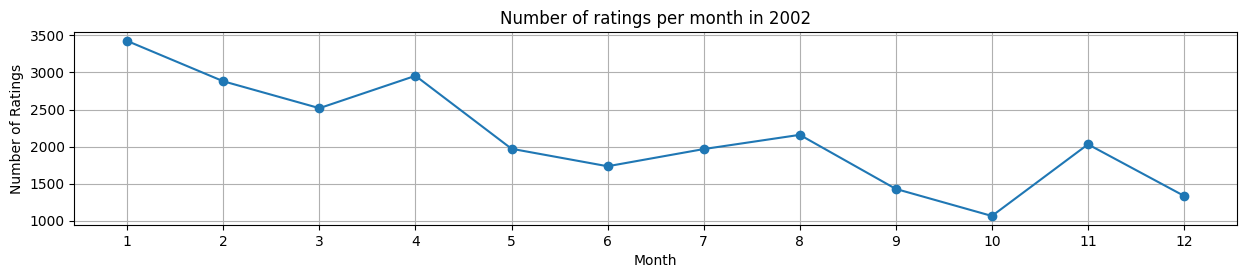

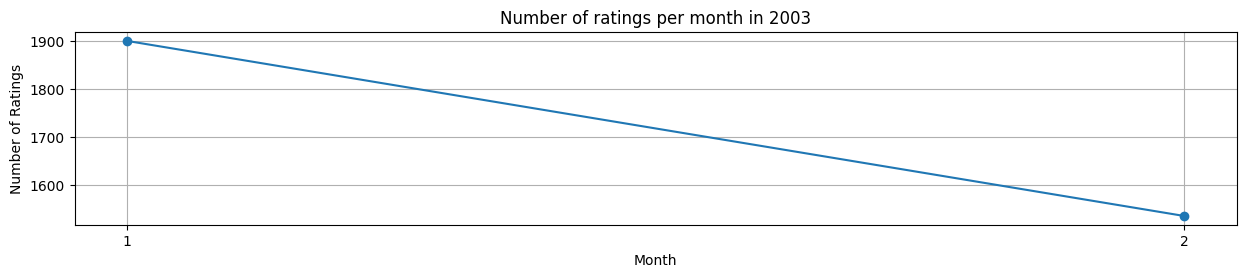

In [ ]:
df_temp = df_rating.groupBy('year', 'month').count().orderBy('year', 'month')
df_temp_pandas = df_temp.toPandas()

unique_years = df_temp_pandas['year'].unique()
for year in unique_years:
    df_year = df_temp_pandas[df_temp_pandas['year'] == year]
    plt.figure(figsize=(15, 2.5))
    plt.plot(df_year['month'], df_year['count'], marker='o')  # Plot as line graph
    plt.title('Number of ratings per month in {}'.format(year))
    plt.xlabel('Month')
    plt.ylabel('Number of Ratings')
    plt.xticks(df_year['month'])  # Set x-ticks to include all months
    plt.grid(True)
    plt.show()

### Distribution of different rating values

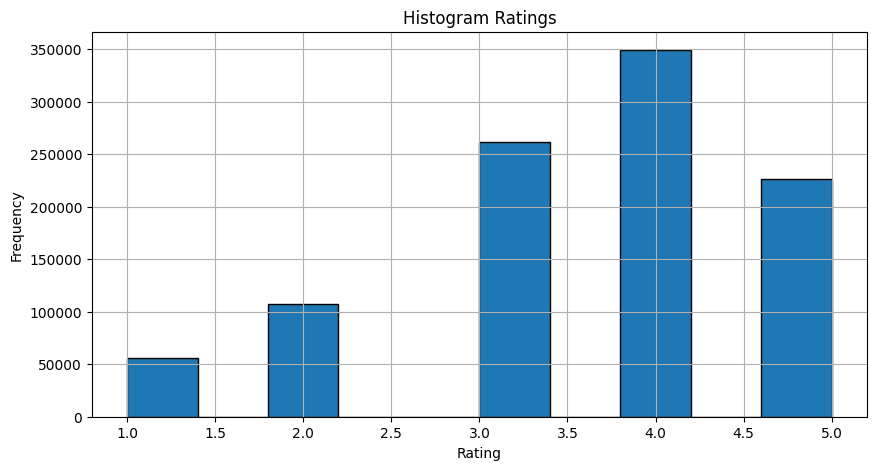

In [ ]:
df = df_rating.withColumn("rating", df_rating["rating"].cast("int"))

df_pandas = df.select("rating").toPandas()

plt.figure(figsize=(10, 5))
plt.hist(df_pandas["rating"], bins=10, edgecolor="black")
plt.title("Histogram Ratings")
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

### How the ratings change over time, LowerB and UpperB using std

In [ ]:
df_temp = df.groupBy("date").agg(mean("Rating").alias("mean"), stddev("Rating").alias("std"))

df_temp = df_temp.withColumn("upper", df_temp["mean"] + df_temp["std"]).withColumn("lower", df_temp["mean"] - df_temp["std"])

df_temp = df_temp.orderBy("date")
df_temp.show(4)
df_temp_pandas = df_temp.toPandas()

df_temp_pandas.reset_index(inplace=True)

+----------+------------------+------------------+-----------------+------------------+
|      date|              mean|               std|            upper|             lower|
+----------+------------------+------------------+-----------------+------------------+
|2000-04-25| 3.877659574468085|0.8149215710196822|4.692581145487767| 3.062738003448403|
|2000-04-26|3.4097472924187726| 1.123586292164251|4.533333584583024|2.2861610002545216|
|2000-04-27| 3.764297167290219|1.0098591660096916|4.774156333299911| 2.754438001280527|
|2000-04-28|3.5650087260034904| 1.057350175297601|4.622358901301091|2.5076585507058895|
+----------+------------------+------------------+-----------------+------------------+
only showing top 4 rows



In [ ]:
df_temp = df.groupBy("date").agg(sum("Rating").alias("sum_day"), count("Rating").alias("count_day"))

df_30ds = df_temp.
# df_temp = df_temp.withColumn("upper", df_temp["mean"] + df_temp["std"]).withColumn("lower", df_temp["mean"] - df_temp["std"])

df_temp = df_temp.orderBy("date")
df_temp.show(4)
df_temp_pandas = df_temp.toPandas()

df_temp_pandas.reset_index(inplace=True)

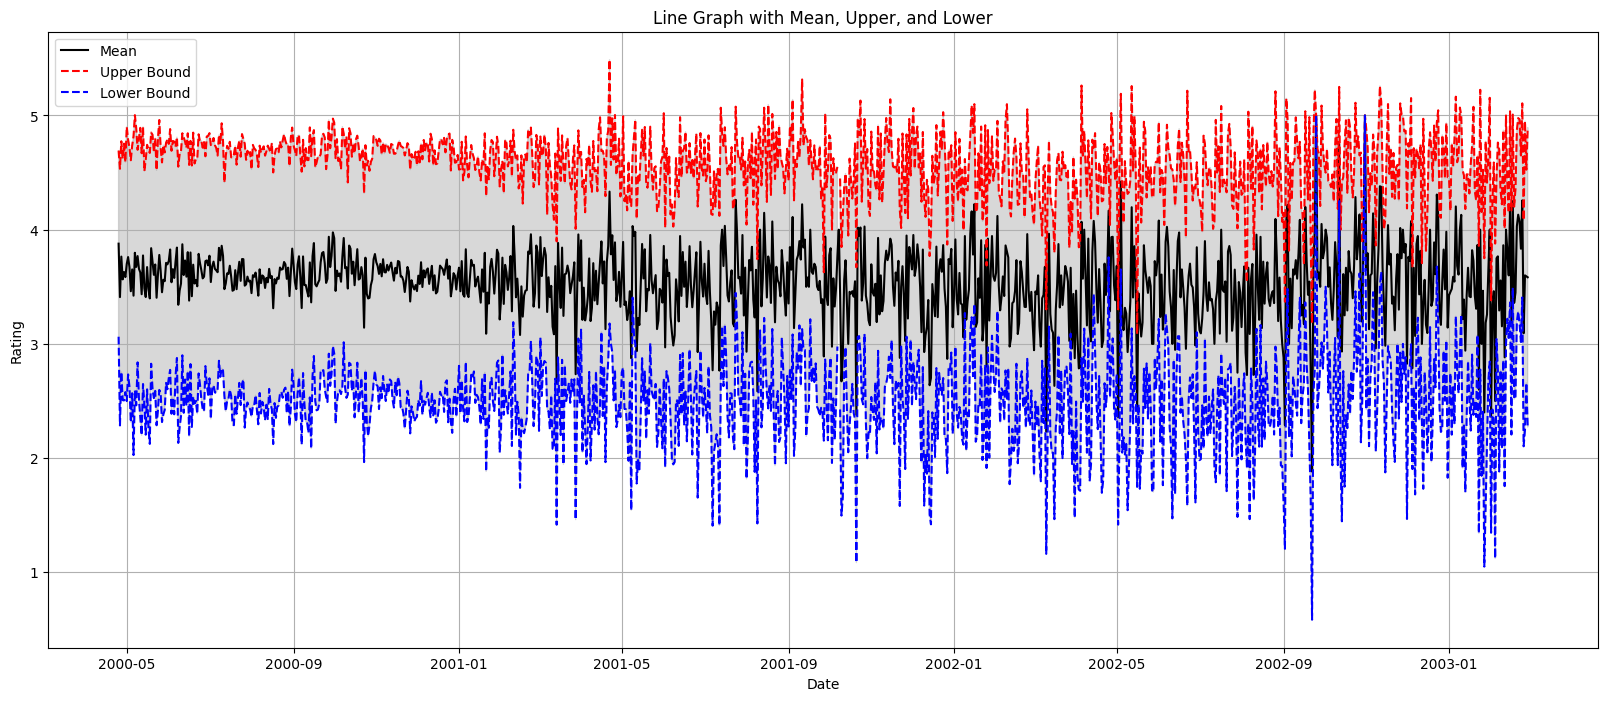

In [ ]:
plt.figure(figsize=(20, 8))
plt.plot(df_temp_pandas['date'], df_temp_pandas['mean'], color="black", label="Mean")
plt.plot(df_temp_pandas['date'], df_temp_pandas['upper'], color="red", linestyle='--', label="Upper Bound")
plt.plot(df_temp_pandas['date'], df_temp_pandas['lower'], color="blue", linestyle='--', label="Lower Bound")
plt.fill_between(df_temp_pandas['date'], df_temp_pandas['upper'], df_temp_pandas['lower'], color="grey", alpha=0.3)
plt.title('Line Graph with Mean, Upper, and Lower')
plt.xlabel("Date")
plt.ylabel("Rating")
plt.legend()
plt.grid(True)
plt.show()

## Users

In [ ]:
# Load users data
users_dat = spark.read.text("/content/drive/MyDrive/Colab Notebooks/BIg Data/users.dat")
users_dat.show(5)

+-------------------+
|              value|
+-------------------+
| 1::F::1::10::48067|
|2::M::56::16::70072|
|3::M::25::15::55117|
| 4::M::45::7::02460|
|5::M::25::20::55455|
+-------------------+
only showing top 5 rows



In [ ]:
# Split the 'value' column into multiple columns
colName = ["UserID", "Gender", "Age", "Occupation", "Zip-code"]
users_rdd = users_dat.withColumn("value", split(users_dat["value"], "::"))
users_df = users_rdd.select([users_rdd.value.getItem(i).alias(colName[i]) for i in range(len(colName))])

# Show the transformed data
users_df.show(5)

+------+------+---+----------+--------+
|UserID|Gender|Age|Occupation|Zip-code|
+------+------+---+----------+--------+
|     1|     F|  1|        10|   48067|
|     2|     M| 56|        16|   70072|
|     3|     M| 25|        15|   55117|
|     4|     M| 45|         7|   02460|
|     5|     M| 25|        20|   55455|
+------+------+---+----------+--------+
only showing top 5 rows



In [ ]:
df_user = users_df

In [ ]:
unique_occupations = df_user.select(countDistinct("Occupation").alias("Unique_occupations")).collect()[0][0]
unique_zipcodes = df_user.select(countDistinct("Zip-code").alias("Unique_zipcodes")).collect()[0][0]
gender_distribution = df_user.groupBy("Gender").count().orderBy(desc("count")).collect()

print('#Unique occupations:', unique_occupations)
print('#Unique zipcodes:', unique_zipcodes)
print('Gender distribution:')
for row in gender_distribution:
    print(row["Gender"], row["count"])

#Unique occupations: 21
#Unique zipcodes: 3439
Gender distribution:
M 4331
F 1709


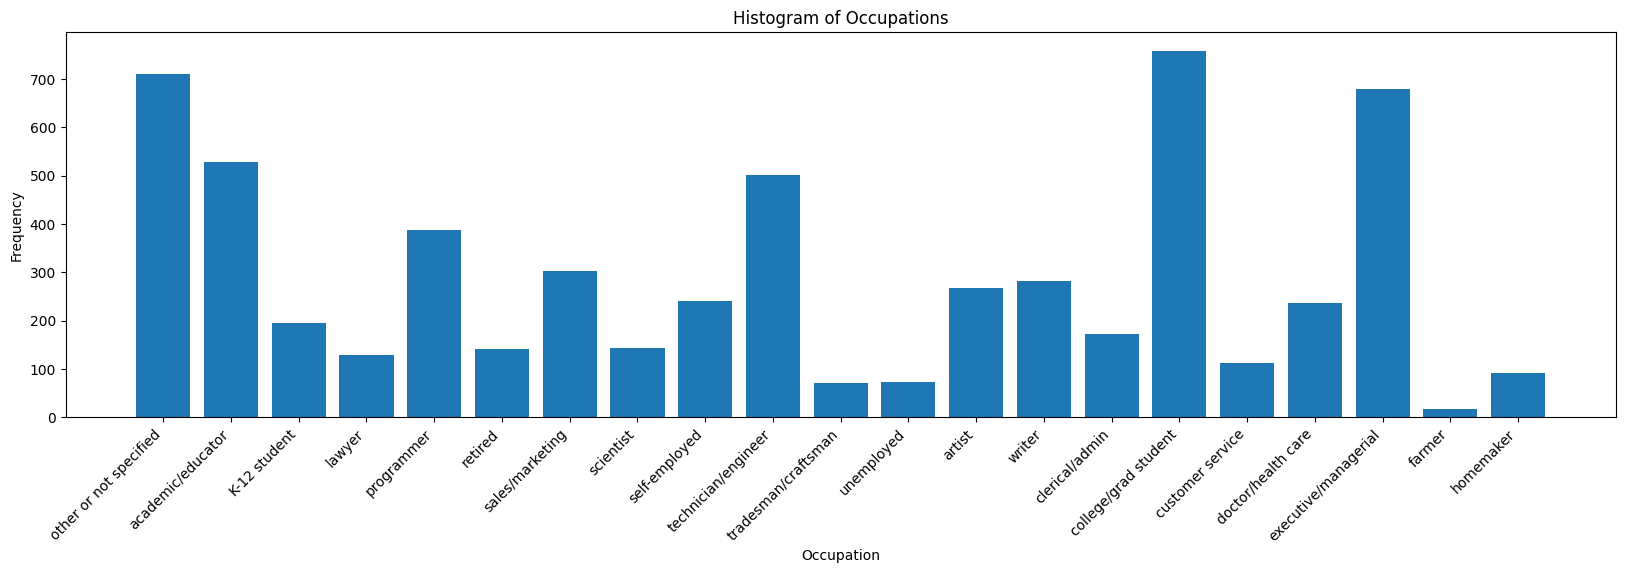

In [ ]:
occupation_counts = df_user.groupBy("Occupation").count().orderBy("occupation")

# Convert Spark DataFrame to Pandas DataFrame
occupation_counts_pandas = occupation_counts.toPandas()

def map_job_to_group(job_idx):
    for key, value in occupation_dict.items():
        if int(job_idx) == key:
            return value
    return "Unknown"

# Map age to age group using the defined function
occupation_counts_pandas["JobGroup"] = occupation_counts_pandas["Occupation"].apply(map_job_to_group)

# Plot the histogram
plt.figure(figsize=(20, 5))
plt.bar(occupation_counts_pandas["JobGroup"], occupation_counts_pandas["count"])
plt.title("Histogram of Occupations")
plt.xlabel("Occupation")
plt.ylabel("Frequency")
plt.xticks(rotation=45, ha='right')
plt.show()

In [ ]:
age_counts = df_user.groupBy("Age").count().orderBy("Age")
# Convert Spark DataFrame to Pandas DataFrame
age_counts_pandas = age_counts.toPandas()

def map_age_to_group(age):
    for key, value in age_group_dict.items():
        if int(age) == key:
            return value
    return "Unknown"

# Map age to age group using the defined function
age_counts_pandas["Age Group"] = age_counts_pandas["Age"].apply(map_age_to_group)

In [ ]:
age_counts_pandas

,Age,count,Age Group
0,1,222,Under 18
1,18,1103,18-24
2,25,2096,25-34
3,35,1193,35-44
4,45,550,45-49
5,50,496,50-55
6,56,380,56+


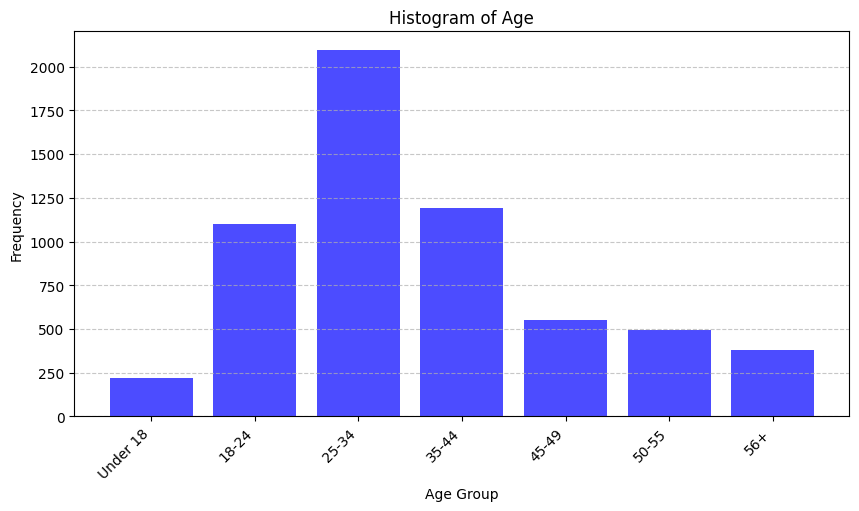

In [ ]:
plt.figure(figsize=(10, 5))
plt.bar(age_counts_pandas["Age Group"], age_counts_pandas["count"], color='blue', alpha=0.7)
plt.title("Histogram of Age")
plt.xlabel("Age Group")
plt.ylabel("Frequency")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
# Step 3: Join ratings with users and movies to get Occupation and Genres
merged_df = ratings_df.join(users_df, "UserID").join(movies_df, "MovieID")

# Split the "Genres" column by "|" or ","
occupation_genres_mean_rating = merged_df.withColumn("Genres", split(col("Genres"), "[|,]"))

# Group by Occupation and explode the array of genres
occupation_genres_mean_rating = occupation_genres_mean_rating.select("Occupation", explode("Genres").alias("Genre"), "Rating")

# Group by Occupation and Genre, calculate the mean rating
occupation_genre_mean_rating = occupation_genres_mean_rating.groupBy("Occupation", "Genre").agg(mean("Rating").alias("MeanRating"))

# Pivot the DataFrame to get Occupation as rows, Genre as columns, and mean rating as values
pivoted_df = occupation_genre_mean_rating.groupBy("Occupation").pivot("Genre").mean("MeanRating").fillna(0)

# Step 6: Convert Spark DataFrame to Pandas DataFrame
pandas_df = pivoted_df.toPandas()

In [ ]:
def map_job_to_group(job_idx):
    for key, value in occupation_dict.items():
        if int(job_idx) == key:
            return value
    return "Unknown"

# Map job to job group using the defined function
pandas_df["Occupation"] = pandas_df["Occupation"].apply(map_job_to_group)

In [ ]:
pandas_df

,Occupation,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,executive/managerial,3.568398,3.509312,3.700937,3.443679,3.517520,3.738499,3.912209,3.766261,3.471940,4.033438,3.220880,3.667928,3.674365,3.611615,3.503046,3.623976,3.909046,3.632994
1,scientist,3.547561,3.563357,3.859048,3.600490,3.681902,3.796238,3.993865,3.825529,3.545098,4.186441,3.340493,3.810345,3.751301,3.690133,3.525248,3.659686,3.904884,3.837887
2,lawyer,3.529328,3.484618,3.726415,3.457959,3.566675,3.750804,4.184466,3.778091,3.524880,4.153707,3.256471,3.719866,3.755037,3.610398,3.483917,3.637163,3.949544,3.671560
3,clerical/admin,3.538175,3.540218,3.791347,3.582746,3.594482,3.740571,3.874598,3.791873,3.449778,4.084722,3.321459,3.834946,3.748611,3.699210,3.548086,3.643334,3.925216,3.634943
4,farmer,3.452164,3.397790,3.525926,3.241636,3.488397,3.587065,3.900000,3.633570,3.441176,3.878049,3.016393,3.560000,3.487805,3.573684,3.405694,3.453094,3.784431,3.705882
5,self-employed,3.521240,3.533830,3.749268,3.482174,3.519974,3.742368,3.949425,3.801041,3.511052,4.115340,3.273480,3.689197,3.704801,3.631557,3.506422,3.575404,3.937314,3.615192
6,other or not specified,3.405677,3.412888,3.652699,3.409470,3.466512,3.640348,3.848733,3.731133,3.406627,4.056911,3.117091,3.636790,3.582410,3.553866,3.391338,3.480823,3.844368,3.616325
7,customer service,3.486201,3.470927,3.753036,3.503663,3.471743,3.682762,3.868687,3.731150,3.403000,4.021021,3.277138,3.637178,3.608516,3.559208,3.448249,3.529222,3.732716,3.612565
8,tradesman/craftsman,3.477159,3.433536,3.744681,3.392718,3.446143,3.635306,3.640000,3.738495,3.419753,3.882653,3.341662,3.482412,3.631250,3.520119,3.476215,3.570048,3.872367,3.753994
9,technician/engineer,3.567495,3.565841,3.736140,3.485406,3.585574,3.714781,4.028497,3.803732,3.531451,4.057707,3.219664,3.658055,3.673984,3.664151,3.534818,3.624560,3.942253,3.665292


In [ ]:
df = pandas_df
df.set_index("Occupation", inplace=True)

In [ ]:
df

,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
Occupation,,,,,,,,,,,,,,,,,,
executive/managerial,3.568398,3.509312,3.700937,3.443679,3.517520,3.738499,3.912209,3.766261,3.471940,4.033438,3.220880,3.667928,3.674365,3.611615,3.503046,3.623976,3.909046,3.632994
scientist,3.547561,3.563357,3.859048,3.600490,3.681902,3.796238,3.993865,3.825529,3.545098,4.186441,3.340493,3.810345,3.751301,3.690133,3.525248,3.659686,3.904884,3.837887
lawyer,3.529328,3.484618,3.726415,3.457959,3.566675,3.750804,4.184466,3.778091,3.524880,4.153707,3.256471,3.719866,3.755037,3.610398,3.483917,3.637163,3.949544,3.671560
clerical/admin,3.538175,3.540218,3.791347,3.582746,3.594482,3.740571,3.874598,3.791873,3.449778,4.084722,3.321459,3.834946,3.748611,3.699210,3.548086,3.643334,3.925216,3.634943
farmer,3.452164,3.397790,3.525926,3.241636,3.488397,3.587065,3.900000,3.633570,3.441176,3.878049,3.016393,3.560000,3.487805,3.573684,3.405694,3.453094,3.784431,3.705882
self-employed,3.521240,3.533830,3.749268,3.482174,3.519974,3.742368,3.949425,3.801041,3.511052,4.115340,3.273480,3.689197,3.704801,3.631557,3.506422,3.575404,3.937314,3.615192
other or not specified,3.405677,3.412888,3.652699,3.409470,3.466512,3.640348,3.848733,3.731133,3.406627,4.056911,3.117091,3.636790,3.582410,3.553866,3.391338,3.480823,3.844368,3.616325
customer service,3.486201,3.470927,3.753036,3.503663,3.471743,3.682762,3.868687,3.731150,3.403000,4.021021,3.277138,3.637178,3.608516,3.559208,3.448249,3.529222,3.732716,3.612565
tradesman/craftsman,3.477159,3.433536,3.744681,3.392718,3.446143,3.635306,3.640000,3.738495,3.419753,3.882653,3.341662,3.482412,3.631250,3.520119,3.476215,3.570048,3.872367,3.753994


In [ ]:
df.index

Index(['executive/managerial', 'scientist', 'lawyer', 'clerical/admin',
       'farmer', 'self-employed', 'other or not specified', 'customer service',
       'tradesman/craftsman', 'technician/engineer', 'doctor/health care',
       'unemployed', 'homemaker', 'academic/educator', 'writer',
       'K-12 student', 'college/grad student', 'programmer', 'retired',
       'sales/marketing', 'artist'],
      dtype='object', name='Occupation')

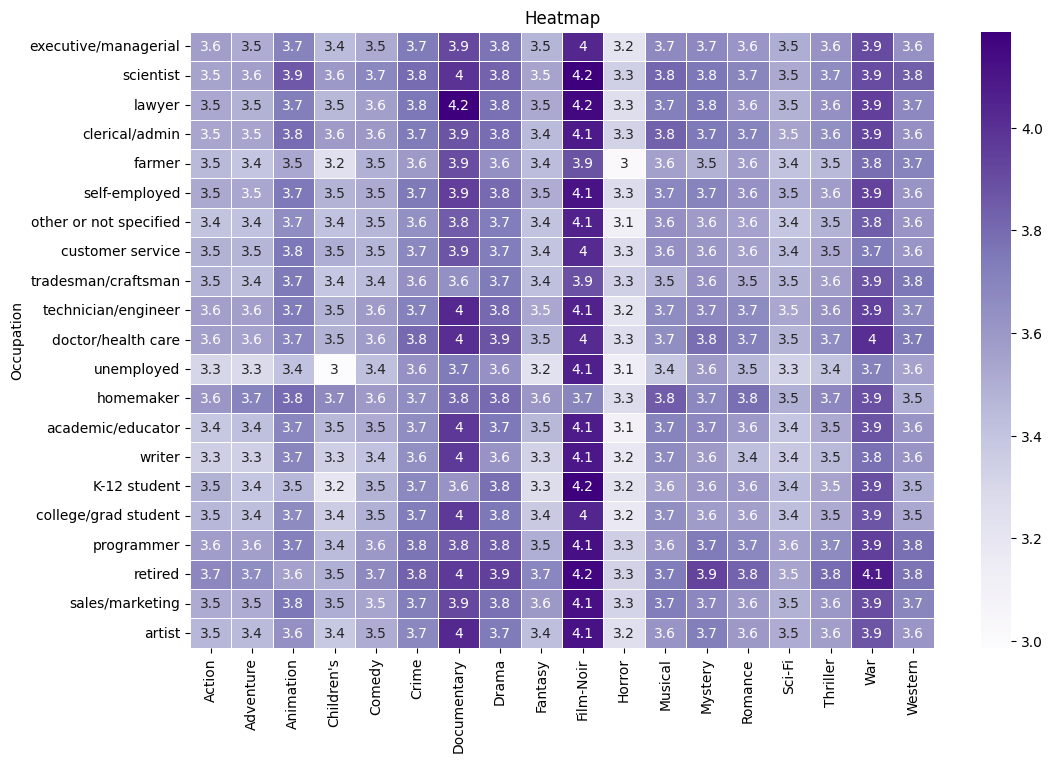

In [ ]:
# Plot the correlation matrix using Seaborn
plt.figure(figsize=(12, 8))
sns.heatmap(df, annot=True, cmap="Purples", linewidths=.5)
plt.title("Heatmap")
plt.yticks(rotation=0)  # Rotate y-axis labels to be horizontal
plt.show()

# Recommendation Algorithm

## Alternating Least Squares

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import CrossValidator
from pyspark.ml.tuning import ParamGridBuilder
from pyspark.sql.types import IntegerType, FloatType

In [ ]:
data = (ratings_df
        .selectExpr("cast(UserID as int) as userId",
                    "cast(MovieID as int) as movieId",
                    "cast(Rating as float) as rating"))

data.show(5)

+------+-------+------+
|userId|movieId|rating|
+------+-------+------+
|     1|   1193|   5.0|
|     1|    661|   3.0|
|     1|    914|   3.0|
|     1|   3408|   4.0|
|     1|   2355|   5.0|
+------+-------+------+
only showing top 5 rows



In [ ]:
movies = (movies_df
          .selectExpr("cast(MovieID as int) as movieId",
                      "Title as title",
                      "Genres as genres"))

movies.show(5)

+-------+--------------------+--------------------+
|movieId|               title|              genres|
+-------+--------------------+--------------------+
|      1|          Toy Story |Animation|Childre...|
|      2|            Jumanji |Adventure|Childre...|
|      3|   Grumpier Old Men |      Comedy|Romance|
|      4|  Waiting to Exhale |        Comedy|Drama|
|      5|Father of the Bri...|              Comedy|
+-------+--------------------+--------------------+
only showing top 5 rows



In [ ]:
# Randomly split the data into train and test where 80% data is in train and remaining is test
train, test = data.randomSplit([0.8, 0.2])

In [ ]:
# Build a recommendation model using Alternating Least Squares method
# Evaluate the model by computing the RMSE on the test data
model = ALS(userCol="userId", itemCol="movieId", ratingCol="rating", nonnegative=True, coldStartStrategy="drop").fit(train)

evaluator=RegressionEvaluator(metricName="rmse",labelCol="rating",predictionCol="prediction")

In [ ]:
# Make predictions and print the RMSE of the ALS model
predictions=model.transform(test)
rmse=evaluator.evaluate(predictions)
print("New RMSE: ", evaluator.evaluate(model.transform(test)))

New RMSE:  0.8737426228338054


In [ ]:
# Now we try to improve the performance of the original model using cross validation and solve the cold-start problem.
# we set cold start strategy to 'drop' to ensure we don't get NaN evaluation metrics

model = ALS(userCol="userId", itemCol="movieId", ratingCol="rating", nonnegative = True, coldStartStrategy="drop")

#For Parameter tuning of the ALS model we use ParamGridBuilder function
#We tune two parameters
#1. The Regularization parameter ranging from 0.1, 0.01, 0.001, 0.0001
#2. The rank for matrix factorization
paramGrid = ParamGridBuilder() \
    .addGrid(model.regParam, [0.1, 0.05, 0.01, 0.001]) \
    .addGrid(model.rank, [5, 10, 20, 30]) \
    .build()

#Defining a cross-validator object
#Setting up CV and adding parameters. We will be performing a 5 fold CV
crossvalidation = CrossValidator(estimator = model,
                     estimatorParamMaps = paramGrid,
                     evaluator = evaluator,
                     numFolds=5)

In [ ]:
# Run cross-validation, and choose the best set of parameters.
Best_model = crossvalidation.fit(train).bestModel

In [ ]:
#The Best_model
print(type(Best_model))
#Complete the code below to extract the ALS model parameters
print("**Best Model**")
#Rank
print("Rank: ", Best_model._java_obj.parent().getRank())
#MaxIter
print("MaxIter: ", Best_model._java_obj.parent().getMaxIter())
#RegParam
print("RegParam: ", Best_model._java_obj.parent().getRegParam())

<class 'pyspark.ml.recommendation.ALSModel'>
**Best Model**
Rank:  10
MaxIter:  10
RegParam:  0.05


In [ ]:
# Calculate the RMSE on test data using the best set of parameters obtained after cross validation
print("Best RMSE value is: ", evaluator.evaluate(Best_model.transform(test)))

Best RMSE value is:  0.8626600843858219


In [ ]:
pred = Best_model.transform(test)
pred.show(10)

+------+-------+------+----------+
|userId|movieId|rating|prediction|
+------+-------+------+----------+
|  4784|    148|   3.0| 3.1159008|
|   840|    148|   1.0|  2.736754|
|  3650|    463|   2.0| 2.4619746|
|  3151|    463|   5.0| 4.2435904|
|  4858|    463|   3.0| 2.5745149|
|  2629|    463|   4.0| 3.2145572|
|  3717|    463|   2.0|  3.002769|
|   721|    463|   4.0| 3.3903484|
|  4613|    463|   4.0| 4.2490134|
|  5511|    463|   2.0|  3.537704|
+------+-------+------+----------+
only showing top 10 rows



In [ ]:
pred.join(movies, "movieId").select("userId","title","genres","rating","prediction").show()

+------+--------------------+--------------------+------+----------+
|userId|               title|              genres|rating|prediction|
+------+--------------------+--------------------+------+----------+
|  4784|Awfully Big Adven...|               Drama|   3.0| 3.1159008|
|   840|Awfully Big Adven...|               Drama|   1.0|  2.736754|
|  3650|      Guilty as Sin |Crime|Drama|Thriller|   2.0| 2.4619746|
|  3151|      Guilty as Sin |Crime|Drama|Thriller|   5.0| 4.2435904|
|  4858|      Guilty as Sin |Crime|Drama|Thriller|   3.0| 2.5745149|
|  2629|      Guilty as Sin |Crime|Drama|Thriller|   4.0| 3.2145572|
|  3717|      Guilty as Sin |Crime|Drama|Thriller|   2.0|  3.002769|
|   721|      Guilty as Sin |Crime|Drama|Thriller|   4.0| 3.3903484|
|  4613|      Guilty as Sin |Crime|Drama|Thriller|   4.0| 4.2490134|
|  5511|      Guilty as Sin |Crime|Drama|Thriller|   2.0|  3.537704|
|  3829|      Guilty as Sin |Crime|Drama|Thriller|   2.0| 1.8625822|
|  3224|      Guilty as Sin |Crime

In [ ]:
# Get top 10 movie recommendations for all users
movie_recommendation = Best_model.recommendForAllUsers(10)
movie_recommendation.show()
import pandas as pd
movie_recommendation = movie_recommendation.toPandas()

+------+--------------------+
|userId|     recommendations|
+------+--------------------+
|  1580|[[2129, 4.9856806...|
|  4900|[[2911, 5.481056]...|
|  5300|[[557, 5.6967254]...|
|   471|[[3338, 4.883591]...|
|  1591|[[557, 5.87029], ...|
|  4101|[[887, 5.7309685]...|
|  1342|[[318, 4.4407644]...|
|  2122|[[527, 4.547532],...|
|  2142|[[318, 4.333978],...|
|   463|[[858, 4.48405], ...|
|   833|[[2964, 5.747669]...|
|  5803|[[1420, 5.337277]...|
|  3794|[[2309, 4.941239]...|
|  1645|[[1117, 6.697052]...|
|  3175|[[53, 4.9283104],...|
|  4935|[[3338, 4.640951]...|
|   496|[[2129, 6.019097]...|
|  2366|[[1471, 4.6148725...|
|  2866|[[858, 4.521614],...|
|  5156|[[557, 5.584928],...|
+------+--------------------+
only showing top 20 rows



In [ ]:
#Get recommendations for all the users into a dataframe
user_list = []
recommendations = []

for i in range(len(movie_recommendation)):
  user_list.append(movie_recommendation.iloc[i,0])
  user_recommendations = ""

  #Get item IDs from the recommendations
  for item in movie_recommendation.iloc[i,1]:
     user_recommendations = user_recommendations + ", " + str(item.asDict()["movieId"])

  #Append the item IDs to recommendations list
  recommendations.append(user_recommendations[2:])

#Convert results into a dataframe
recommendations_df = pd.DataFrame(data = zip(user_list, recommendations), columns=["user", "MovieID"])

In [ ]:
#Check the users and the top 10 movie recommendations for the first 10 users
recommendations_df.head(10)

,user,MovieID
0,1580,"2129, 2562, 2063, 3817, 3645, 3855, 1046, 3136..."
1,4900,"2911, 3092, 1846, 3737, 318, 1117, 2329, 2999,..."
2,5300,"557, 2309, 1423, 681, 2360, 53, 296, 858, 1743..."
3,471,"3338, 2999, 557, 1901, 750, 2905, 1204, 2019, ..."
4,1591,"557, 1423, 53, 3517, 787, 1901, 2503, 3338, 23..."
5,4101,"887, 3314, 3161, 108, 3303, 598, 2834, 1879, 4..."
6,1342,"318, 593, 527, 2762, 1851, 2324, 110, 50, 858,..."
7,2122,"527, 858, 3092, 953, 318, 1207, 1250, 912, 593..."
8,2142,"318, 593, 50, 1851, 2028, 2762, 858, 527, 2309..."
9,463,"858, 2309, 2905, 50, 1221, 296, 1213, 1193, 19..."


In [ ]:
#write into a csv file
recommendations_df.to_csv('/content/drive/MyDrive/Colab Notebooks/BIg Data/recommendation_results.csv', sep='\t', index=False)

In [ ]:
import pandas as pd
from pyspark.sql.functions import col

user_id = 542

user_rec = recommendations_df[recommendations_df['user'] == user_id]

rec_movie_ids = user_rec['MovieID'].iloc[0].split(', ')
rec_movie_ids = [int(id) for id in rec_movie_ids]
print("Recommendation for user", user_id, ":")

for rec_movie_id in rec_movie_ids:
    movie_title = movies.filter(col('movieId') == rec_movie_id).select('title').collect()[0][0]
    print(movie_title)

Recommendation for user 542 :
Saltmen of Tibet, The 
Bandits 
Careful 
Talk of Angels 
Bewegte Mann, Der 
Best Man, The 
Line King: Al Hirschfeld, The 
Sanjuro 
Hard Core Logo 
Perfect Blue 


In [ ]:
movies.show(5)

+-------+--------------------+--------------------+
|movieId|               title|              genres|
+-------+--------------------+--------------------+
|      1|          Toy Story |Animation|Childre...|
|      2|            Jumanji |Adventure|Childre...|
|      3|   Grumpier Old Men |      Comedy|Romance|
|      4|  Waiting to Exhale |        Comedy|Drama|
|      5|Father of the Bri...|              Comedy|
+-------+--------------------+--------------------+
only showing top 5 rows



## Cosine Similarity

In [ ]:
from pyspark.sql import functions as F
ratings = ratings_df.select("UserID", "MovieID", "Rating")
moviesNames = movies_df.select("MovieID", "Title")

ratings.show(5)
moviesNames.show(5)

+------+-------+------+
|UserID|MovieID|Rating|
+------+-------+------+
|     1|   1193|     5|
|     1|    661|     3|
|     1|    914|     3|
|     1|   3408|     4|
|     1|   2355|     5|
+------+-------+------+
only showing top 5 rows

+-------+--------------------+
|MovieID|               Title|
+-------+--------------------+
|      1|          Toy Story |
|      2|            Jumanji |
|      3|   Grumpier Old Men |
|      4|  Waiting to Exhale |
|      5|Father of the Bri...|
+-------+--------------------+
only showing top 5 rows



In [ ]:
moviePairs = ratings.alias("ratings1") \
    .join(ratings.alias("ratings2"), (F.col("ratings1.userID") == F.col("ratings2.userID")) & (F.col("ratings1.movieID") < F.col("ratings2.movieID"))) \
    .select(F.col("ratings1.movieID").alias("movie1ID"),
            F.col("ratings2.movieID").alias("movie2ID"),
            F.col("ratings1.rating").alias("rating1"),
            F.col("ratings2.rating").alias("rating2")) \
    .repartition(100)

In [ ]:
def findSimilarity(spark, data):
    pairScores = data \
        .withColumn("xx", F.col("rating1") * F.col("rating1")) \
        .withColumn("yy", F.col("rating2") * F.col("rating2")) \
        .withColumn("xy", F.col("rating1") * F.col("rating2"))

    calculSimilarity = pairScores \
        .groupBy("movie1ID", "movie2ID") \
        .agg(
            F.sum(F.col("xy")).alias("numerator"),
            (F.sqrt(F.sum(F.col("xx"))) * F.sqrt(F.sum(F.col("yy")))).alias("denominator"),
            F.count(F.col("xy")).alias("numPairs")
        )

    result = calculSimilarity \
        .withColumn("score",
            F.when(F.col("denominator") != 0, F.col("numerator") / F.col("denominator"))
            .otherwise(None)) \
        .select("movie1ID", "movie2ID", "score", "numPairs")

    return result

In [ ]:
moviePairSimilarities = findSimilarity(spark, moviePairs).cache()

In [ ]:
movieID = "1"  # Toy Story, by default

scoreThreshold = 0.97
coOccurenceThreshold = 1000.0

# Filter for movies with this sim that are "good" as defined by
# our quality thresholds above
filteredResults = moviePairSimilarities.filter(
    ((F.col("movie1ID") == movieID) | (F.col("movie2ID") == movieID)) &
    (F.col("score") > scoreThreshold) & (F.col("numPairs") > coOccurenceThreshold)
)

results = filteredResults.sort(F.col("score").desc()).take(10)

In [ ]:
# Convert results to DataFrame
results_df = spark.createDataFrame(results, ["movie1ID", "movie2ID", "score", "numPairs"])

# Coalesce DataFrame to have only one partition
results_df = results_df.coalesce(1)

# Save DataFrame to CSV file
results_df.write.option("header","true").csv("/content/drive/MyDrive/Colab Notebooks/BIg Data/results.csv")

In [ ]:
def getMovieName(movieNames, movieId):
    result = movieNames.filter(F.col("movieID") == movieId) \
        .select("Title").collect()[0]

    return result[0]

In [ ]:
print("\nTop 10 similar movies for " + getMovieName(moviesNames, movieID))
for result in results:
    # Display the similarity result that isn't the movie we're looking at
    similarMovieID = result.movie1ID
    if similarMovieID == movieID:
        similarMovieID = result.movie2ID
    print(getMovieName(moviesNames, similarMovieID) + "\tscore: " + str(result.score) + "\tstrength: " + str(result.numPairs))


Top 10 similar movies for Toy Story 
Toy Story 2 	score: 0.9863196644836282	strength: 1116
Bug's Life, A 	score: 0.9772120819552946	strength: 1081
Raiders of the Lost Ark 	score: 0.9762747821879435	strength: 1224
Shawshank Redemption, The 	score: 0.9744376433430181	strength: 1151
Back to the Future 	score: 0.9726186483168096	strength: 1331
Star Wars: Episode IV - A New Hope 	score: 0.9721270419610062	strength: 1382
Aladdin 	score: 0.9714438113571542	strength: 1024
Schindler's List 	score: 0.9712527723586235	strength: 1093
Star Wars: Episode V - The Empire Strikes Back 	score: 0.9710534127613166	strength: 1393
Princess Bride, The 	score: 0.9707858677321519	strength: 1223


# End

In [ ]:
# Stop SparkSession
spark.stop()